In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from peewee import *
from datetime import date, datetime, timedelta
import matplotlib.dates as mdates
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
db = MySQLDatabase('airfaresdwh', user='root', password='toor', host='localhost', autocommit=True)

In [4]:
class DimFlight(Model):

    flightKey = CharField(max_length=255)
    flightID = AutoField(primary_key=True, index=True)
    flightNumber = CharField(max_length=50)
    departureDate = DateField()
    arrivalDate = DateField()
    departureTime = TimeField()
    arrivalTime = TimeField()
    journeyDuration = TimeField()
    totalNumberOfStops = IntegerField()
    startDate = DateField()
    endDate = DateField()

    class Meta:
        database = db

class DimAirline(Model):
    carrierID = AutoField(primary_key=True)
    carrierCode = CharField(max_length=10)
    carrierName = CharField(max_length=50)

    class Meta:
        database = db

class DimAirport(Model):
    airportID = AutoField(primary_key=True)
    airportCode = CharField(max_length=10)
    airportName = CharField(max_length=50)
    city = CharField(max_length=50)
    country = CharField(max_length=50)

    class Meta:
        database = db

class DimDate(Model):
    dateID = IntegerField(primary_key=True)
    fullDate = DateField()
    dayOfMonth = IntegerField()
    dayOfYear = IntegerField()
    dayOfWeek = IntegerField()
    dayName = CharField(max_length=10)
    monthNumber = IntegerField()
    monthName = CharField(max_length=10)
    year = IntegerField()
    isItWeekend = IntegerField()
    isItVacationDay = IntegerField()
    week_of_year = CharField(max_length=2)
    quarter = IntegerField()
    previous_day = DateField()
    next_day = DateField()

    class Meta:
        database = db

class FactFlights(Model):
    factID = AutoField()
    scrapeDateID = IntegerField()
    depAirportID = IntegerField()
    arrAirportID = IntegerField()
    flightID = IntegerField()
    carrierID = IntegerField()
    departureDateID = IntegerField()
    arrivalDateID = IntegerField()
    availableSeats = IntegerField()
    adultPrice = FloatField()

    class Meta:
        database = db

    def create_foreign_keys(self):
        self.flightID = ForeignKeyField(DimFlight, backref='fact_flights')
        self.carrierID = ForeignKeyField(DimAirline, backref='fact_flights')
        self.depAirportID = ForeignKeyField(DimAirport, backref='fact_flights_dep')
        self.arrAirportID = ForeignKeyField(DimAirport, backref='fact_flights_arr')
        self.departureDateID = ForeignKeyField(DimDate, backref='fact_flights_dep')
        self.arrivalDateID = ForeignKeyField(DimDate, backref='fact_flights_arr')
        self.scrapeDateID = ForeignKeyField(DimDate, backref='fact_flights_scrape')



In [5]:
db.connect()
query1 = DimFlight.select().dicts()
query2 = DimDate.select().dicts()
query3 = DimAirport.select().dicts()
query4 = DimAirline.select().dicts()
query5 = FactFlights.select().dicts()

flight_data = list(query1)
date_data = list(query2)
airport_data = list(query3)
airline_data = list(query4)
fact_flights_data = list(query5)

df_flight = pd.DataFrame(flight_data)
df_date = pd.DataFrame(date_data)
df_airport = pd.DataFrame(airport_data)
df_airline = pd.DataFrame(airline_data)
df_fact_flights = pd.DataFrame(fact_flights_data)
db.close()

True

### (1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

##### Ryanair

In [9]:
ryanair_mean_price = df_fact_flights[df_fact_flights['carrierID'] == 3]['adultPrice'].mean()
ryanair_mean_price

115.7288261749494

##### Tui

In [10]:
tui_mean_price = df_fact_flights[df_fact_flights['carrierID'] == 2]['adultPrice'].mean()
tui_mean_price

200.67144448373406

##### Transavia

In [11]:
transavia_mean_price = df_fact_flights[df_fact_flights['carrierID'] == 1]['adultPrice'].mean()
transavia_mean_price

146.58736317831702

Text(0.5, 0, 'Gemiddlede prijs')

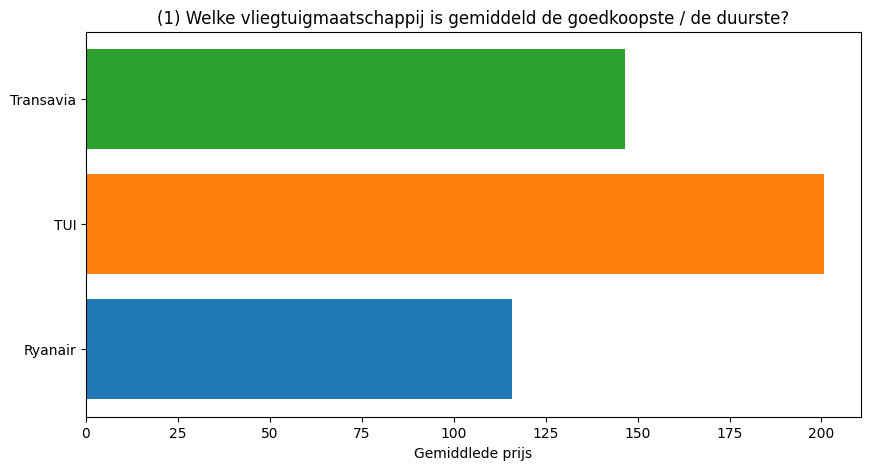

In [12]:
plt.figure(figsize=(10, 5))

carrier_codes = ['FR', 'TB', 'HV']
carrier_names = ['Ryanair', 'TUI', 'Transavia']

carrier_mean_prices = [ryanair_mean_price, tui_mean_price, transavia_mean_price]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.barh(carrier_names, carrier_mean_prices, color=colors)
plt.title('(1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?')
plt.xlabel('Gemiddlede prijs')

### (8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

In [6]:
df_date['fullDate'] = pd.to_datetime(df_date['fullDate'])
df_date = df_date.drop(df_date.index[184:])
df_date = df_date.reset_index(drop=True)

In [7]:
df_flight_on_vacation_day = pd.merge(df_fact_flights, df_date, left_on='departureDateID', right_on='dateID')

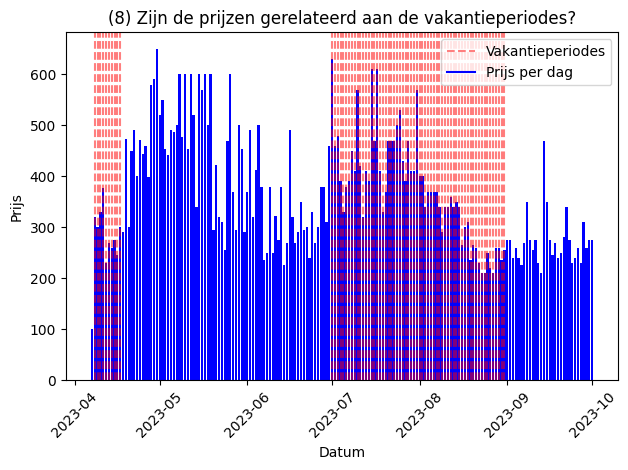

In [8]:
plt.bar(df_flight_on_vacation_day['fullDate'], df_flight_on_vacation_day['adultPrice'], color='blue', label='Prijs per dag')

for _, row in df_date.iterrows():
    if row['isItVacationDay'] == 1:
        plt.axvline(x=row['fullDate'], color='red', linestyle='--', alpha=0.5)

plt.title('(8) Zijn de prijzen gerelateerd aan de vakantieperiodes?')
plt.xlabel('Datum')
plt.ylabel('Prijs')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()

red_line = plt.Line2D([], [], color='red', linestyle='--', alpha=0.5, label='Vakantieperiodes')
blue_line = plt.Line2D([], [], color='blue', label='Prijs per dag')
plt.legend(handles=[red_line, blue_line], loc='upper right')

plt.show()

### (9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

In [16]:
df_date = df_date.drop(df_date.index[184:])
df_date = df_date.reset_index(drop=True)

df_total = pd.merge(df_fact_flights, df_date, left_on='departureDateID', right_on='dateID')

# unix timestamp to datetime
df_total['scrapeDateID'] = pd.to_datetime(df_total['scrapeDateID'], unit='s')
df_total['scrapeDateID'] = df_total['scrapeDateID'] + timedelta(hours=2)

df_total['departureDateID'] = pd.to_datetime(df_total['departureDateID'], unit='s')
df_total['departureDateID'] = df_total['departureDateID'] + timedelta(hours=2)

# nieuwe kolom met verschil in dagen tussen scrapeDateID en departureDateID
df_total['fullDate'] = pd.to_datetime(df_total['fullDate'])

df_total['daysBeforeDeparture'] = df_total['fullDate'] - df_total['scrapeDateID']
df_total['daysBeforeDeparture'] = df_total['daysBeforeDeparture'].dt.days

# arrAirportName toevoegen
df_total = pd.merge(df_total, df_airport, left_on='arrAirportID', right_on='airportID')

# nutteloze kolommen verwijderen
df_total = df_total.drop(['dayName', 'arrivalDateID', 'dayOfYear', 'isItWeekend', 'dateID', 'factID', 'depAirportID', 'arrAirportID', 'flightID', 'quarter', 'airportID', 'airportName', 'previous_day', 'next_day', 'week_of_year'], axis=1)

# opsplitsen in 3 dataframes voor de 3 carriers
df_ryanair = df_total[df_total['carrierID'] == 3]
df_transavia = df_total[df_total['carrierID'] == 1]
df_tui = df_total[df_total['carrierID'] == 2]

df_total.head(5)

,scrapeDateID,carrierID,departureDateID,availableSeats,adultPrice,fullDate,dayOfMonth,dayOfWeek,monthNumber,monthName,year,isItVacationDay,daysBeforeDeparture,airportCode,city,country
0,2023-04-07,3,2023-04-08,2,205.75,2023-04-08,8,7,4,April,2023,1,1,HER,Heraklion,Greece
1,2023-04-07,1,2023-04-08,6,175.00,2023-04-08,8,7,4,April,2023,1,1,HER,Heraklion,Greece
2,2023-04-07,3,2023-04-11,4,156.69,2023-04-11,11,3,4,April,2023,1,4,HER,Heraklion,Greece
3,2023-04-07,1,2023-04-11,1,117.00,2023-04-11,11,3,4,April,2023,1,4,HER,Heraklion,Greece
4,2023-04-08,3,2023-04-11,4,205.75,2023-04-11,11,3,4,April,2023,1,3,HER,Heraklion,Greece


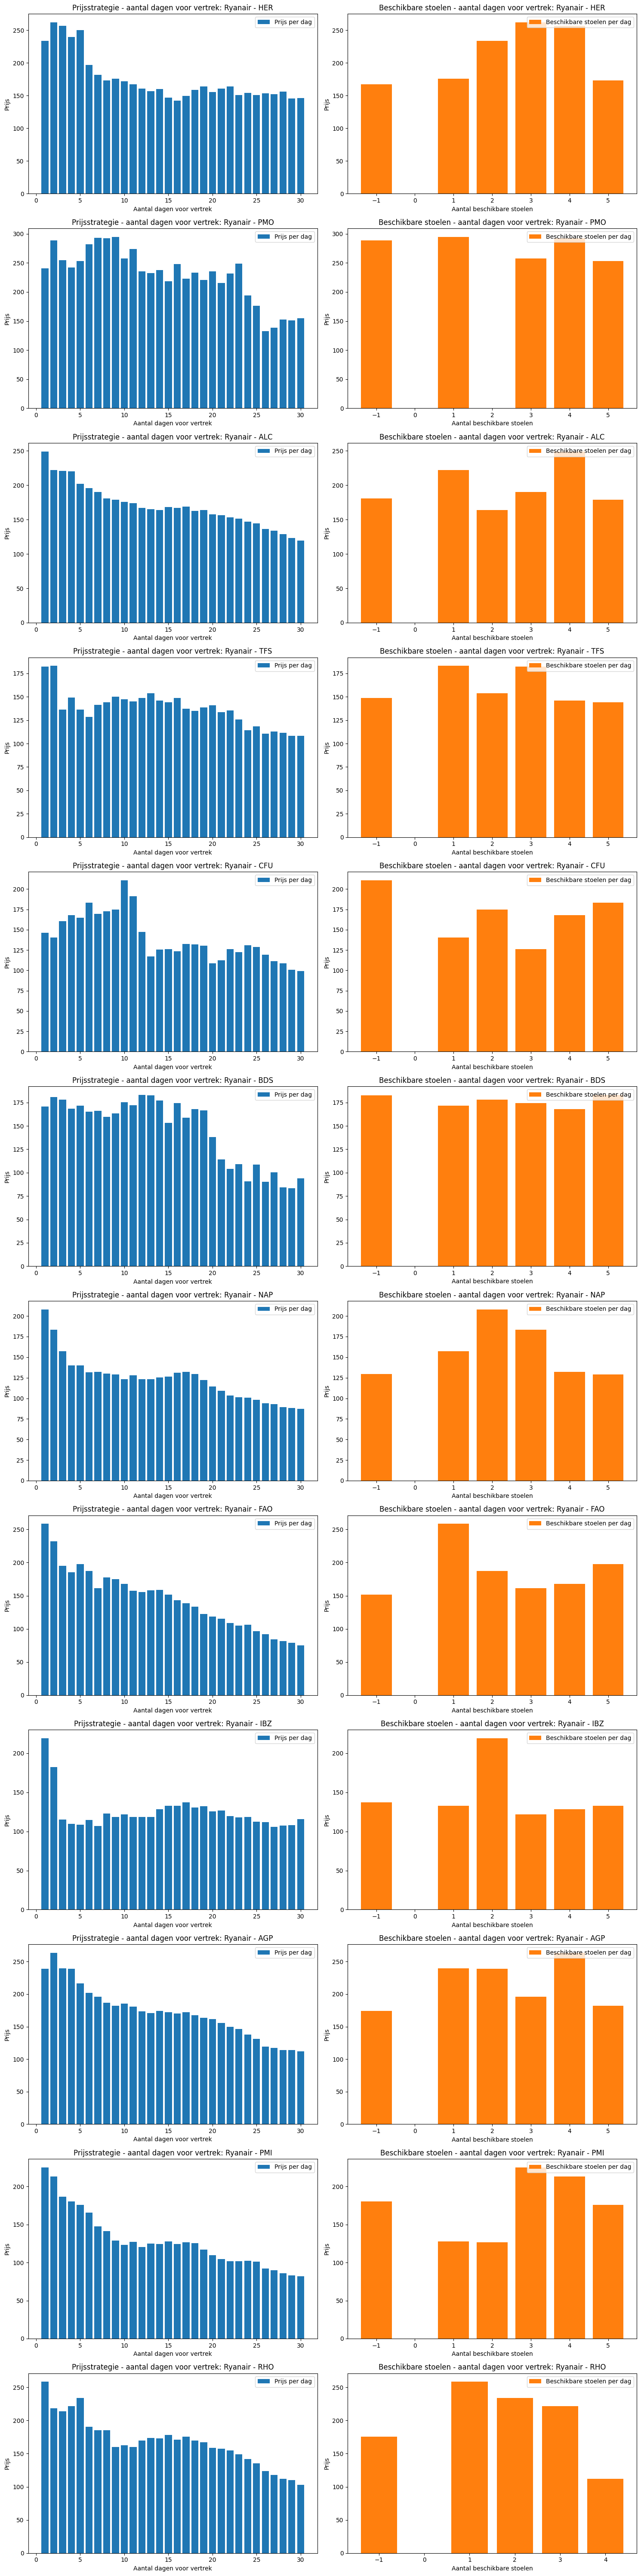

In [17]:
fig, axs = plt.subplots(len(df_ryanair['airportCode'].unique()), 2, figsize=(15, 5 * len(df_ryanair['airportCode'].unique())))

for i, airport in enumerate(df_ryanair['airportCode'].unique()):
    df_airport = df_ryanair[df_ryanair['airportCode'] == airport]
    df_airport = df_airport[df_airport['daysBeforeDeparture'] <= 30]
    
    df_airport['meanPrice'] = df_airport.groupby('daysBeforeDeparture')['adultPrice'].transform('mean')
    df_airport = df_airport.drop_duplicates(subset=['daysBeforeDeparture'])

    df_airport['meanSeats'] = df_airport.groupby('daysBeforeDeparture')['availableSeats'].transform('mean')
    df_airport = df_airport.drop_duplicates(subset=['daysBeforeDeparture'])

    ax1 = axs[i, 0] if len(df_ryanair['airportCode'].unique()) > 1 else axs[0]
    ax2 = axs[i, 1] if len(df_ryanair['airportCode'].unique()) > 1 else axs[1]
    
    ax1.bar(df_airport['daysBeforeDeparture'], df_airport['meanPrice'], color='#1f77b4', label='Prijs per dag')
    ax1.set_title(f'Prijsstrategie - aantal dagen voor vertrek: Ryanair - {airport}')
    ax1.set_xlabel('Aantal dagen voor vertrek')
    ax1.set_ylabel('Prijs')
    ax1.legend(loc='upper right')
    
    ax2.bar(df_airport['availableSeats'], df_airport['meanPrice'], color='#ff7f0e', label='Beschikbare stoelen per dag')
    ax2.set_title(f'Beschikbare stoelen - aantal dagen voor vertrek: Ryanair - {airport}')
    ax2.set_xlabel('Aantal beschikbare stoelen')
    ax2.set_ylabel('Prijs')
    ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()


### (12) Hoeveel dagen voor vertrek is een vlucht volgeboekt? Zijn er bestemmingen waarbij de vluchten bijna volgeboekt zijn?

C:\Users\buyse\AppData\Local\Temp\ipykernel_23844\1632042391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fully_booked_df['days_before_departure'] = (pd.to_datetime(fully_booked_df['departureDateID'], unit='s') - pd.to_datetime(fully_booked_df['scrapeDateID'], unit='s')).dt.days


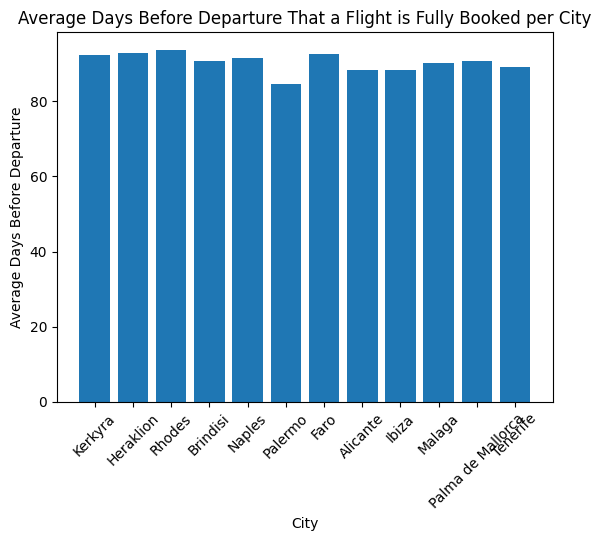

In [23]:
fully_booked_df = df_fact_flights[df_fact_flights['availableSeats'] == -1] 

fully_booked_df['days_before_departure'] = (pd.to_datetime(fully_booked_df['departureDateID'], unit='s') - pd.to_datetime(fully_booked_df['scrapeDateID'], unit='s')).dt.days

average_days_before_departure = fully_booked_df.groupby('arrAirportID')['days_before_departure'].mean()

city_names = df_airport[df_airport['airportID'].isin(average_days_before_departure.index)]['city']

plt.bar(city_names, average_days_before_departure)
plt.xlabel('City')
plt.ylabel('Average Days Before Departure')
plt.title('Average Days Before Departure That a Flight is Fully Booked per City')
plt.xticks(rotation=45)
plt.show()

### (13) Hoeveel procent van de vluchten zijn volgeboekt? / Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek.

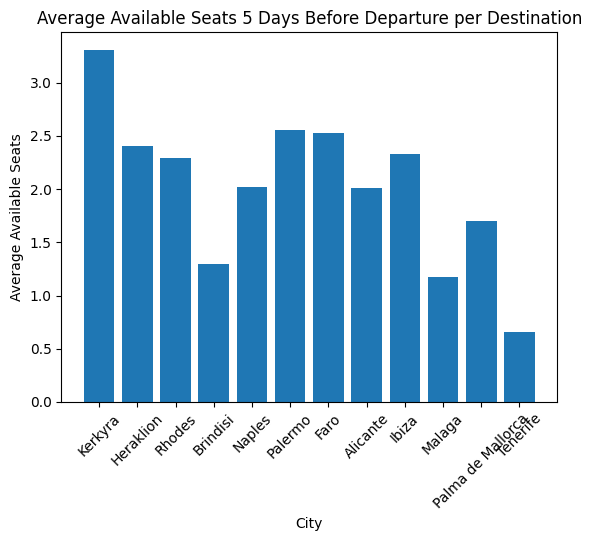

In [24]:
depDate = pd.to_datetime(df_fact_flights['departureDateID'], unit='s')
scrapeDate = pd.to_datetime(df_fact_flights['scrapeDateID'], unit='s') 

filtered_df = df_fact_flights[depDate - scrapeDate == timedelta(days=5)] 
grouped_df = filtered_df.groupby('arrAirportID') 

average_available_seats_per_destination = grouped_df['availableSeats'].mean()

city_names = df_airport[df_airport['airportID'].isin(average_available_seats_per_destination.index)]['city']

plt.bar(city_names, average_available_seats_per_destination)
plt.xlabel('City')
plt.ylabel('Average Available Seats')
plt.title('Average Available Seats 5 Days Before Departure per Destination')
plt.xticks(rotation=45)
plt.show()

### (14 a.)  Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand

Alle data van ryanair

C:\Users\buyse\AppData\Local\Temp\ipykernel_23844\3673065926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ryanair_flights['days_before_departure'] = (pd.to_datetime(ryanair_flights['departureDateID'], unit='s') - pd.to_datetime(ryanair_flights['scrapeDateID'], unit='s')).dt.days


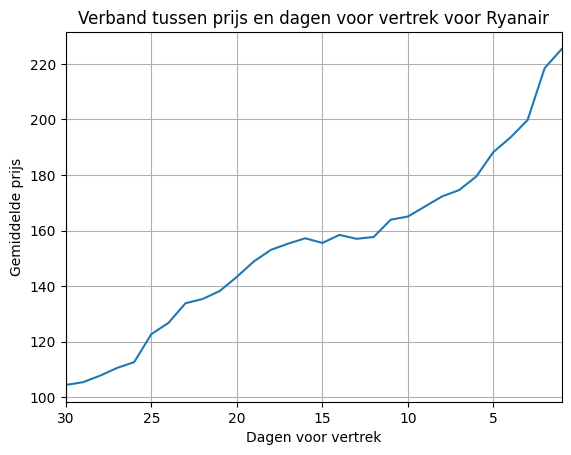

In [25]:
ryanair_flights = df_fact_flights[df_fact_flights['carrierID'] == 3] 

ryanair_flights['days_before_departure'] = (pd.to_datetime(ryanair_flights['departureDateID'], unit='s') - pd.to_datetime(ryanair_flights['scrapeDateID'], unit='s')).dt.days

ryanair_flights_30_days = ryanair_flights[ryanair_flights['days_before_departure'] <= 30]

average_prices = ryanair_flights_30_days.groupby('days_before_departure')['adultPrice'].mean().sort_index(ascending=False)

plt.plot(average_prices.index, average_prices.values)
plt.xlabel('Dagen voor vertrek')
plt.ylabel('Gemiddelde prijs')
plt.title('Verband tussen prijs en dagen voor vertrek voor Ryanair')
plt.xlim(max(average_prices.index), min(average_prices.index))
plt.grid()
plt.show()

Alleen data van afgelopen maand

C:\Users\buyse\AppData\Local\Temp\ipykernel_23844\2318104720.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ryanair_flights['days_before_departure'] = (pd.to_datetime(ryanair_flights['departureDateID'], unit='s') - pd.to_datetime(ryanair_flights['scrapeDateID'], unit='s')).dt.days


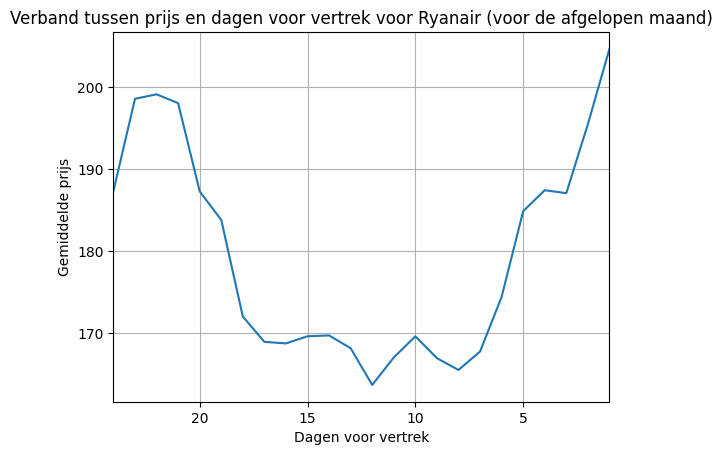

In [30]:
one_month_ago = datetime.now() - timedelta(days=30)

ryanair_flights = df_fact_flights[(df_fact_flights['carrierID'] == 3) & 
                                  (pd.to_datetime(df_fact_flights['departureDateID'], unit='s').dt.month == one_month_ago.month)]

ryanair_flights['days_before_departure'] = (pd.to_datetime(ryanair_flights['departureDateID'], unit='s') - pd.to_datetime(ryanair_flights['scrapeDateID'], unit='s')).dt.days

ryanair_flights_30_days = ryanair_flights[ryanair_flights['days_before_departure'] <= 30]

average_prices = ryanair_flights_30_days.groupby('days_before_departure')['adultPrice'].mean().sort_index(ascending=False)

plt.plot(average_prices.index, average_prices.values)
plt.xlabel('Dagen voor vertrek')
plt.ylabel('Gemiddelde prijs')
plt.title('Verband tussen prijs en dagen voor vertrek voor Ryanair (voor de afgelopen maand)')
plt.xlim(max(average_prices.index), min(average_prices.index))
plt.grid()
plt.show()

### (14 b.) Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand

In [188]:
df_date = df_date.drop(df_date.index[184:])
df_date = df_date.reset_index(drop=True)

df_total = pd.merge(df_fact_flights, df_date, left_on='departureDateID', right_on='dateID')

# unix timestamp to datetime
df_total['scrapeDateID'] = pd.to_datetime(df_total['scrapeDateID'], unit='s')
df_total['scrapeDateID'] = df_total['scrapeDateID'] + timedelta(hours=2)

df_total['departureDateID'] = pd.to_datetime(df_total['departureDateID'], unit='s')
df_total['departureDateID'] = df_total['departureDateID'] + timedelta(hours=2)

# nieuwe kolom met verschil in dagen tussen scrapeDateID en departureDateID
df_total['fullDate'] = pd.to_datetime(df_total['fullDate'])

df_total['daysBeforeDeparture'] = df_total['fullDate'] - df_total['scrapeDateID']
df_total['daysBeforeDeparture'] = df_total['daysBeforeDeparture'].dt.days

# arrAirportName toevoegen
df_total = pd.merge(df_total, df_airport, left_on='arrAirportID', right_on='airportID')

# nutteloze kolommen verwijderen
df_total = df_total.drop(['dayName', 'dayOfWeek', 'monthName', 'arrivalDateID', 'dayOfYear', 'isItWeekend', 'dateID', 'factID', 'depAirportID', 'arrAirportID', 'flightID', 'quarter', 'airportID', 'airportName', 'previous_day', 'next_day', 'week_of_year'], axis=1)

one_month_ago = datetime.now() - timedelta(days=30)

df_ryanair = df_total[df_total['carrierID'] == 3]
df_ryanair = df_ryanair[df_ryanair['departureDateID'].dt.month == one_month_ago.month]

df_ryanair = df_ryanair[df_ryanair['daysBeforeDeparture'] <= 30]
df_ryanair.drop(['carrierID', 'country', 'airportCode', 'fullDate', 'scrapeDateID', 'departureDateID'], axis=1, inplace=True)

df_ryanair.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2353 entries, 0 to 159130
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   availableSeats       2353 non-null   int64  
 1   adultPrice           2353 non-null   float64
 2   dayOfMonth           2353 non-null   int64  
 3   monthNumber          2353 non-null   int64  
 4   year                 2353 non-null   int64  
 5   isItVacationDay      2353 non-null   int64  
 6   daysBeforeDeparture  2353 non-null   int32  
 7   city                 2353 non-null   object 
dtypes: float64(1), int32(1), int64(5), object(1)
memory usage: 156.3+ KB


One Hot Encoding for city

In [189]:
cities = df_ryanair['city']

encoded_cities = pd.get_dummies(cities, prefix='city')

df_ryanair = pd.concat([df_ryanair, encoded_cities], axis=1)

df_ryanair.drop(['city'], axis=1, inplace=True)
df_ryanair.head(5)

,availableSeats,adultPrice,dayOfMonth,monthNumber,year,isItVacationDay,daysBeforeDeparture,city_Alicante,city_Brindisi,city_Faro,city_Heraklion,city_Ibiza,city_Kerkyra,city_Malaga,city_Naples,city_Palermo,city_Palma de Mallorca,city_Rhodes,city_Tenerife
0,2,205.75,8,4,2023,1,1,False,False,False,True,False,False,False,False,False,False,False,False
2,4,156.69,11,4,2023,1,4,False,False,False,True,False,False,False,False,False,False,False,False
4,4,205.75,11,4,2023,1,3,False,False,False,True,False,False,False,False,False,False,False,False
6,3,204.23,11,4,2023,1,2,False,False,False,True,False,False,False,False,False,False,False,False
8,3,204.23,11,4,2023,1,1,False,False,False,True,False,False,False,False,False,False,False,False


In [190]:
df_ryanair.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2353 entries, 0 to 159130
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   availableSeats          2353 non-null   int64  
 1   adultPrice              2353 non-null   float64
 2   dayOfMonth              2353 non-null   int64  
 3   monthNumber             2353 non-null   int64  
 4   year                    2353 non-null   int64  
 5   isItVacationDay         2353 non-null   int64  
 6   daysBeforeDeparture     2353 non-null   int32  
 7   city_Alicante           2353 non-null   bool   
 8   city_Brindisi           2353 non-null   bool   
 9   city_Faro               2353 non-null   bool   
 10  city_Heraklion          2353 non-null   bool   
 11  city_Ibiza              2353 non-null   bool   
 12  city_Kerkyra            2353 non-null   bool   
 13  city_Malaga             2353 non-null   bool   
 14  city_Naples             2353 non-null   boo

In [192]:
X = df_ryanair.drop(['adultPrice'], axis=1)
y = df_ryanair['adultPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()

model = LinearRegression()

# pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
model.fit(X_train, y_train)

# pipeline.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('accuracy_score:', model.score(X_test, y_test))



Mean Absolute Error: 44.177281730770105
Mean Squared Error: 3297.2652815265114
Root Mean Squared Error: 57.421818862924496
accuracy_score: 0.5434510123592607


Predicten voor volgende maand

In [193]:
df_next_month = df_total[df_total['departureDateID'].dt.month == one_month_ago.month + 1]

df_next_month = df_next_month[df_next_month['daysBeforeDeparture'] <= 30]
df_next_month = df_next_month[df_next_month['carrierID'] == 3]
df_next_month.drop(['carrierID', 'country', 'airportCode', 'fullDate', 'scrapeDateID', 'departureDateID'], axis=1, inplace=True)

df_next_month.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7435 entries, 287 to 160560
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   availableSeats       7435 non-null   int64  
 1   adultPrice           7435 non-null   float64
 2   dayOfMonth           7435 non-null   int64  
 3   monthNumber          7435 non-null   int64  
 4   year                 7435 non-null   int64  
 5   isItVacationDay      7435 non-null   int64  
 6   daysBeforeDeparture  7435 non-null   int32  
 7   city                 7435 non-null   object 
dtypes: float64(1), int32(1), int64(5), object(1)
memory usage: 493.7+ KB


In [194]:
cities = df_next_month['city']

encoded_cities = pd.get_dummies(cities, prefix='city')

df_next_month = pd.concat([df_next_month, encoded_cities], axis=1)
df_next_month_prices = df_next_month[['adultPrice', 'daysBeforeDeparture']]
df_next_month.drop(['city', 'adultPrice'], axis=1, inplace=True)
df_next_month.reset_index(drop=True, inplace=True)

df_next_month.head(5)

,availableSeats,dayOfMonth,monthNumber,year,isItVacationDay,daysBeforeDeparture,city_Alicante,city_Brindisi,city_Faro,city_Heraklion,city_Ibiza,city_Kerkyra,city_Malaga,city_Naples,city_Palermo,city_Palma de Mallorca,city_Rhodes,city_Tenerife
0,1,2,5,2023,0,25,False,False,False,True,False,False,False,False,False,False,False,False
1,-1,2,5,2023,0,24,False,False,False,True,False,False,False,False,False,False,False,False
2,-1,2,5,2023,0,23,False,False,False,True,False,False,False,False,False,False,False,False
3,-1,2,5,2023,0,22,False,False,False,True,False,False,False,False,False,False,False,False
4,-1,2,5,2023,0,21,False,False,False,True,False,False,False,False,False,False,False,False


In [195]:
next_month_prices = model.predict(df_next_month)

df_next_month_prices = pd.DataFrame(df_next_month_prices)
df_next_month_prices['predictedPrice'] = next_month_prices
df_next_month_prices['difference'] = df_next_month_prices['predictedPrice'] - df_next_month_prices['adultPrice']
df_next_month_prices['difference'] = df_next_month_prices['difference'].abs()
df_next_month_prices['difference'] = df_next_month_prices['difference'].round(2)
df_next_month_prices['predictedPrice'] = df_next_month_prices['predictedPrice'].round(2)
df_next_month_prices.reset_index(drop=True, inplace=True)

df_next_month_prices

,adultPrice,daysBeforeDeparture,predictedPrice,difference
0,131.82,25,-241.22,373.04
1,151.70,24,-227.01,378.71
2,175.54,23,-217.83,393.37
3,175.54,22,-208.65,384.19
4,162.99,21,-199.46,362.45
...,...,...,...,...
7430,64.46,25,173.13,108.67
7431,62.97,24,182.31,119.34
7432,62.97,23,191.49,128.52
7433,62.97,22,200.68,137.71


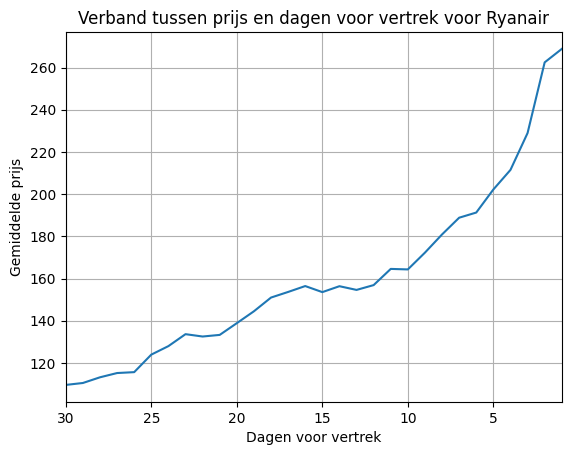

In [198]:
average_prices = df_next_month_prices.groupby('daysBeforeDeparture')['adultPrice'].mean().sort_index(ascending=False)

plt.plot(average_prices.index, average_prices.values)
plt.xlabel('Dagen voor vertrek')
plt.ylabel('Gemiddelde prijs')
plt.title('Verband tussen prijs en dagen voor vertrek voor Ryanair')
plt.xlim(max(average_prices.index), min(average_prices.index))
plt.grid()
plt.show()